#  Amazon Fine Food Reviews Analysis

### Singular value decomposition


In linear algebra, the singular value decomposition (SVD) is a factorization of a real or complex matrix. It is the generalization of the eigendecomposition of a positive semidefinite normal matrix (for example, a symmetric matrix with positive eigenvalues) to any {\displaystyle m\times n} m\times n matrix via an extension of the polar decomposition. It has many useful applications in signal processing and statistics.


The singular value decomposition can be computed using the following observations:
<ul>
<li>The left-singular vectors of M are a set of orthonormal eigenvectors of MM∗.
<li>The right-singular vectors of M are a set of orthonormal eigenvectors of M∗M.
<li>The non-negative singular values of M (found on the diagonal entries of Σ) are the square roots of the non-negative eigenvalues of both M∗M and MM∗.</li></ul>
    
Applications that employ the SVD include computing the pseudoinverse, least squares fitting of data, multivariable control, matrix approximation, and determining the rank, range, and null space of a matrix.

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [35]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from tqdm import tqdm
import os

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [2]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [3]:
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

In [4]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [5]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [8]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████| 87773/87773 [00:51<00:00, 1719.43it/s]


In [25]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

In [26]:
final['Text'] = preprocessed_reviews
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,dogs love saw pet store tag attached regarding...


In [28]:
Data = final.sample(40000)

In [29]:
X = Data['Text']
y = Data['Score']
X.shape

(40000,)

## Reusable Code

In [30]:
# Evaluate the Co-occurence matrix with context window '5'
def co_matrix(data, vocab, context_window=5):
    a = pd.DataFrame(np.zeros((len(vocab), len(vocab))), index=vocab, columns=vocab)
    for review in data:
        words = review.split()
        for idx in range(len(words)):
            if a.get(words[idx]) is None:
                continue
            for i in range(1, context_window+1):
                if idx-i >= 0:
                    if a.get(words[idx-i]) is not None:
                        a[words[idx-i]].loc[words[idx]] = a.get(words[idx-i]).loc[words[idx]] + 1
                        a[words[idx]].loc[words[idx-i]] = a.get(words[idx]).loc[words[idx-i]] + 1
                if idx+i < len(words):
                    if a.get(words[idx+i]) is not None:
                        a[words[idx+i]].loc[words[idx]] = a.get(words[idx+i]).loc[words[idx]] + 1
                        a[words[idx]].loc[words[idx+i]] = a.get(words[idx]).loc[words[idx+i]] + 1
    np.fill_diagonal(a.values, 0)
    return a

In [32]:
def Word_Cloud(df):
    from wordcloud import WordCloud, STOPWORDS

    cloud = " ".join(word for word in df)
    stopwords = set(STOPWORDS) 
    wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 8)) 
    plt.imshow(wordcloud, interpolation = 'bilinear') 
    plt.axis("off") 
    #plt.title("Top 100 most important features\n")
    plt.tight_layout(pad = 0) 
  
    plt.show()

##  TF-IDF

In [38]:
vectorizer_tfidf=TfidfVectorizer(max_features=10000,min_df=5)
vectors=vectorizer_tfidf.fit_transform(X)
vectors=preprocessing.normalize(vectors)

In [39]:
%%time
# Evaluate and store the top 3000 TFIDF Vectors and their corresponding words idf_ gives the weight
indices = np.argsort(vectorizer_tfidf.idf_)[::-1]
features = vectorizer_tfidf.get_feature_names()
top_n = 3000
top_feats = [features[i] for i in indices[:top_n]]
top_idf = [vectorizer_tfidf.idf_[i] for i in indices[:top_n]]

Wall time: 581 ms


In [40]:
co_matrix = co_matrix(X,top_feats)

In [41]:
counter = 0
for i in co_matrix.index:
    if counter == 20:
        break
    for j in co_matrix.index:
        if co_matrix.loc[j][i] != 0:
            print (i,j,"===>", co_matrix.loc[j][i])
            counter += 1

tandoori network ===> 2.0
kg vit ===> 4.0
litters feces ===> 2.0
litters adhere ===> 2.0
litters studied ===> 2.0
litters pine ===> 4.0
litters chore ===> 2.0
amoretti thirdly ===> 2.0
amoretti tiramisu ===> 2.0
porcini bait ===> 4.0
shark appreciates ===> 2.0
stiks puzzled ===> 2.0
stiks responsibly ===> 2.0
stiks braised ===> 2.0
stiks welcomed ===> 2.0
turf pointy ===> 2.0
turf wks ===> 2.0
turf surf ===> 18.0
turf digests ===> 2.0
turf fromm ===> 4.0


### Dim-reduction using Truncated SVD and get the Top Singular Values explaining the most variance

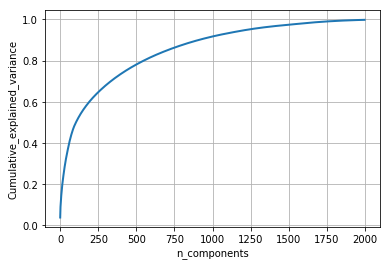

In [42]:
svd = TruncatedSVD(n_components=1999, random_state=42)
svd_matrix = svd.fit_transform(co_matrix)
cum_var_explained = np.cumsum(svd.explained_variance_ratio_)

# Plot the Truncated SVD spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

### Finding the best valve number of cluster 

Starting Cluster #2
Starting Cluster #4
Starting Cluster #5
Starting Cluster #7
Starting Cluster #8
Starting Cluster #10
Starting Cluster #12
Starting Cluster #13
Starting Cluster #15


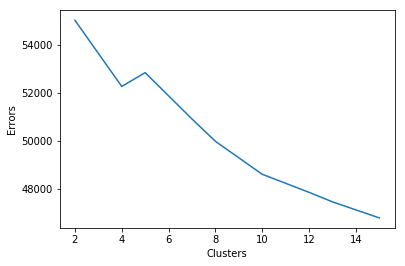

In [43]:
errors = []; clusters = [2, 4, 5, 7, 8, 10,12,13,15];
for i in clusters:
    print(f'Starting Cluster #{i}')
    model = KMeans(n_clusters=i, random_state=42, verbose=0)
    model.fit(svd_matrix)
    errors.append(model.inertia_)

plt.plot(clusters, errors)
plt.xlabel('Clusters')
plt.ylabel('Errors')
plt.show()

In [47]:
model = KMeans(n_clusters=4, random_state=42, verbose=0)
model.fit(svd_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [48]:
df=pd.DataFrame(svd_matrix)
df['Cluster_labels']=model.labels_
df['Words']= top_feats

Total no of Words in cluster 0 is 2992


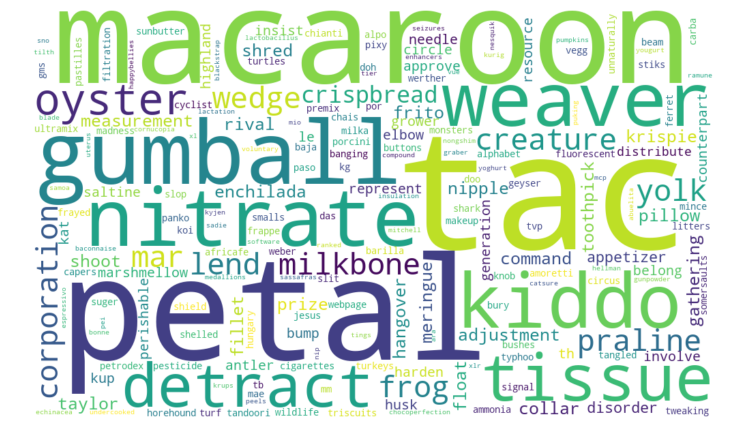

Total no of Words in cluster 1 is 1


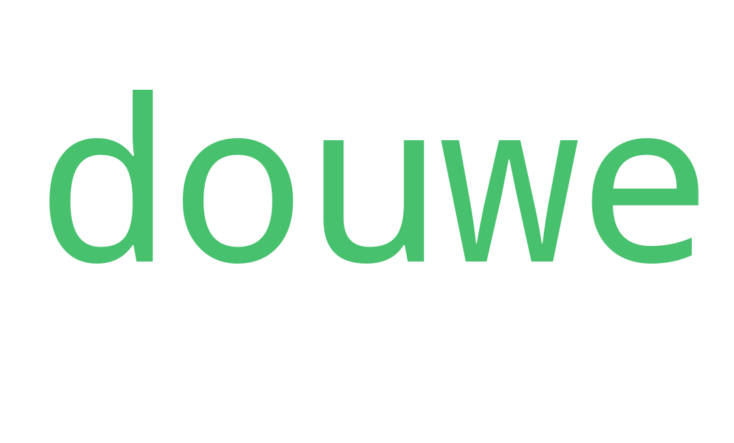

Total no of Words in cluster 2 is 1


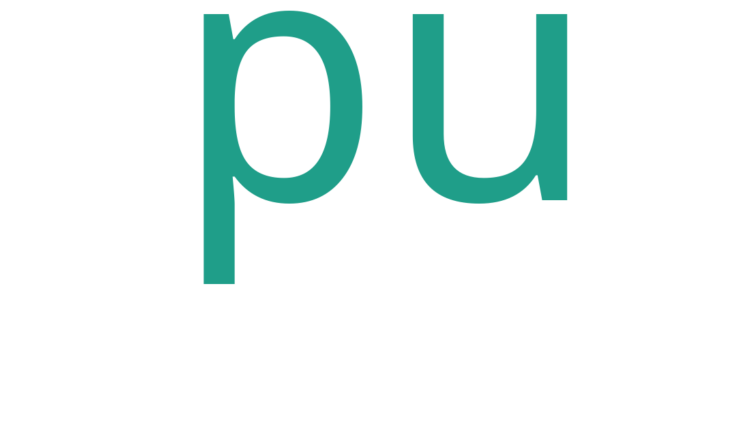

Total no of Words in cluster 3 is 6


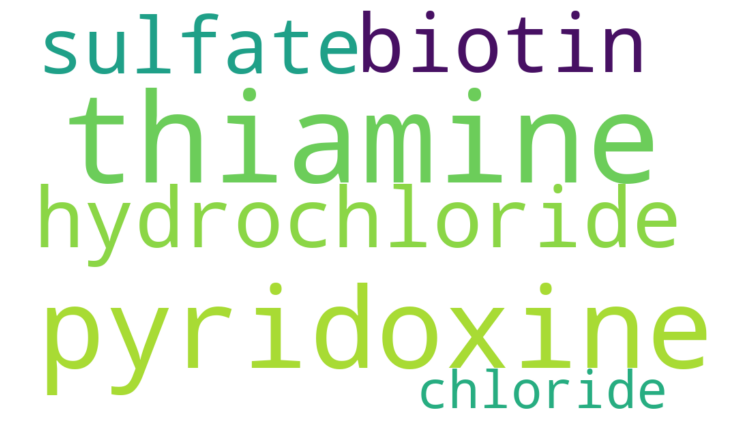

In [49]:
for i in range(model.n_clusters):
    l=list()
    
    # Group at each label 
    label = df.groupby(["Cluster_labels"]).groups[i]
    
    for j in range(len(label)):
        l.append(df.loc[label[j]]["Words"])
    print("Total no of Words in cluster {} is {}".format(i,len(label)))
    Word_Cloud(l)

### Create the Cosine Similarity matrix 

In [50]:
SVD_DF = pd.DataFrame(svd_matrix, index=co_matrix.index)
SVD_DF.head()

,0,1,2,3,4,5,6,7,8,9,...,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998
tandoori,6.528288e-08,-1.108977e-14,1.192519e-05,1.879803e-07,1.529996e-10,1.345389e-07,1.013520e-16,6.240811e-08,5.513032e-07,3.883044e-04,...,0.031375,0.042270,0.004816,-0.012826,0.050791,-0.006047,0.009688,0.001442,0.027848,-0.000795
kg,1.267480e-11,-1.417058e-14,1.504068e-08,2.021654e-07,1.789941e-11,6.038460e-09,6.318703e-16,1.609512e-10,4.040291e-08,6.596404e-06,...,0.001144,0.002855,0.003323,-0.002066,0.003089,-0.002510,0.001120,-0.003737,-0.001578,0.000475
litters,8.120748e-06,1.380807e-15,5.525283e-04,1.305343e-06,2.999880e-07,6.012958e-07,-8.401545e-15,6.132031e-06,1.527802e-05,9.895145e-03,...,-0.017616,-0.011064,-0.016094,-0.023369,-0.011468,-0.008457,-0.008062,-0.009400,-0.016633,0.004127
amoretti,1.035571e-13,2.556814e-16,1.719201e-10,2.114301e-10,3.819579e-07,4.150119e-12,-3.514925e-15,1.226695e-11,4.258651e-04,1.104969e-07,...,0.016123,0.002680,0.006546,0.004646,-0.003498,-0.018625,-0.007219,0.002348,0.010259,0.005542
porcini,7.758263e-12,-5.498001e-16,5.852195e-09,6.016098e-09,2.713803e-05,1.922298e-09,3.507766e-15,2.518196e-10,6.816769e-03,2.747890e-06,...,0.007987,-0.007173,-0.011434,-0.001368,0.002472,-0.004804,0.001244,0.002779,0.003020,-0.011711


In [51]:
sim_matrix = pd.DataFrame(cosine_similarity(SVD_DF), index=co_matrix.index, columns=co_matrix.index)
vocab = list(sim_matrix.index)
sim_matrix.head()

,tandoori,kg,litters,amoretti,porcini,horehound,shark,stiks,turf,turkeys,...,orangina,woody,spry,shreds,theaters,buddies,injury,cairn,insomnia,progress
tandoori,1.000000,-0.000045,-0.000009,-0.000013,-0.000045,-0.030455,-7.819619e-06,0.000404,-6.835080e-07,-0.000539,...,0.000013,0.0,0.000043,0.0,0.000203,0.001064,0.000236,0.007313,0.000025,0.000389
kg,-0.000045,1.000000,0.000010,-0.000032,-0.000003,0.011001,2.857570e-08,0.000026,-3.180171e-07,-0.000012,...,0.000052,0.0,-0.000006,0.0,0.000020,0.000013,0.000011,0.000047,0.000005,0.000009
litters,-0.000009,0.000010,1.000000,-0.000017,-0.000046,0.017339,-1.560641e-06,0.000067,-5.307087e-06,0.000085,...,0.000141,0.0,-0.000071,0.0,-0.000083,-0.000018,0.000026,-0.000027,0.000044,0.000052
amoretti,-0.000013,-0.000032,-0.000017,1.000000,-0.000041,-0.017018,4.129878e-07,0.000147,-5.180178e-06,-0.000007,...,0.000271,0.0,-0.000034,0.0,0.000010,-0.000213,0.000020,0.000035,0.000058,0.000011
porcini,-0.000045,-0.000003,-0.000046,-0.000041,1.000000,-0.017819,5.496243e-07,0.000049,1.095663e-06,0.000055,...,0.000011,0.0,0.000007,0.0,-0.000206,0.000014,-0.000003,0.000034,0.000046,0.000106


In [54]:
def print_similar_words(query):
    print(f'Top 10 similar words to "{query}" :-\n')
    top_idx = np.argsort(sim_matrix[query].values)[1:11]
    [print(vocab[i], sim_matrix[query].iloc[i]) for i in top_idx]

print_similar_words('chloride')

Top 10 similar words to "chloride" :-

werther -0.024036069410675816
paso -0.02151284881969339
slop -0.010588833597662403
filtration -0.0098860721261643
catsure -0.009577671587915068
commands -0.006763381751761812
specifications -0.006751444886428046
baja -0.005707986143668801
happybellies -0.0044350530512620315
mm -0.004056353897976362


## ThankYou